<h1 style="font-size:3rem; color: darkmagenta;">Data Aggregation and Group Operations:</h1>

Data aggregation and group operations are often crucial components of a data analysis workflow. After loading, merging, and preparing a dataset, you may need to categorize the dataset into groups and apply functions to each group, whether for aggregation or transformation purposes. This process is essential for calculating group statistics, generating reports, or creating visualizations, and pandas provides a flexible 'groupby' interface that allows you to slice, dice, and summarize datasets naturally.

The popularity of relational databases and SQL (Structured Query Language) is partly due to their ability to easily join, filter, transform, and aggregate data. However, SQL and similar query languages have limitations when it comes to the variety of group operations that can be performed. As you'll discover, Python and pandas offer great expressiveness, enabling you to perform complex group operations using any function that accepts pandas objects or NumPy arrays. In this tutorial, you will learn how to:

- Split a pandas object into multiple parts using one or more keys (in the form of functions, arrays, or DataFrame column names).
- Calculate group summary statistics, such as counts, means, or standard deviations, or even user-defined functions.
- Apply within-group transformations or other operations, like normalization, linear regression, ranking, or subset selection.
- Compute pivot tables and cross-tabulations.
- Perform quantile analysis and other statistical group analyses.

<h1 style="font-size:2.3rem; color: darkcyan;">10.1 GroupBy Mechanics:</h1>

## Table of Contents

- 10.11  **[GroupBy Mechanics](#GroupBy)**
   
- 10.12  **[Iterating Over Groups](#Iterating)**

- 10.13  **[Selecting a Column or Subset of Columns](#Selecting)**

- 10.14  **[Grouping with Dicts and Series](#Dicts)**
   
- 10.15  **[Grouping with Functions](#Functions)**

- 10.16  **[Grouping by Index Levels](#Index)**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

<a id="GroupBy"></a>
## 10.11 GroupBy Mechanics

Hadley Wickham, a renowned contributor to R programming language packages, introduced the concept of "split-apply-combine" to explain group operations. In the initial stage of this process, data within a pandas object, whether it's a Series, DataFrame, or another data structure, is divided into groups based on one or more criteria that you specify. This division occurs along a particular axis of the data structure. For instance, you can group a DataFrame by its rows (axis=0) or its columns (axis=1). Once the data is grouped, a function is applied independently to each group, producing a new value or set of values for each. Finally, the outcomes of these function applications are merged or combined into a single result object. The format of this resulting object typically depends on the specific data manipulation being performed. You can envision this process as shown in Figure 10-1, which provides a simplified illustration of a basic group aggregation.

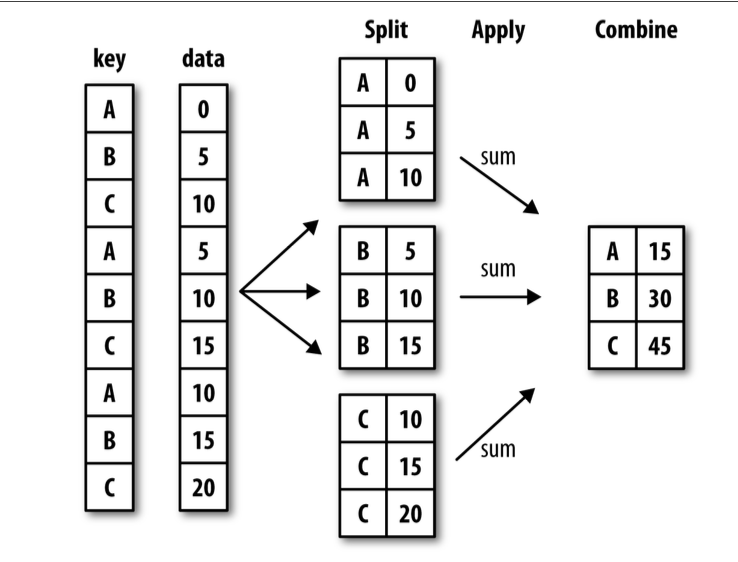

Each grouping key can take many forms, and the keys do not have to be all of the same type:
- A list or array of values that is the same length as the axis being grouped 
- A value indicating a column name in a DataFrame
- A dict or Series giving a correspondence between the values on the axis being grouped and the group names
- A function to be invoked on the axis index or the individual labels in the index

Note that the latter three methods are shortcuts for producing an array of values to be used to split up the object. Don’t worry if this all seems abstract. Throughout this chapter, we will go through many examples of all these methods. To get started, here is a small tabular dataset as a DataFrame:

In [3]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.105038,-0.456879
1,a,two,-0.978405,0.439965
2,b,one,0.023362,1.384081
3,b,two,1.220334,-0.979522
4,a,one,-0.804801,-0.869273


Suppose you wanted to compute the mean of the data1 column using the labels from `key1`. There are a number of ways to do this. One is to access `data1` and call groupby with the column (a Series) at `key1`:

In [4]:
grouped = df['data1'].groupby(df['key1'])
grouped

This `grouped` variable is now a *GroupBy* object. It has not actually computed anything yet except for some intermediate data about the group key `df['key1']`. The idea is that this object has all of the information needed to then apply some operation to each of the groups. For example, to compute group means we can call the GroupBy’s `mean` method:

In [5]:
grouped.mean()

key1
a   -0.629415
b    0.621848
Name: data1, dtype: float64

In [6]:
grouped.sum()

key1
a   -1.888244
b    1.243697
Name: data1, dtype: float64

In [8]:
grouped.head()

0   -0.105038
1   -0.978405
2    0.023362
3    1.220334
4   -0.804801
Name: data1, dtype: float64

Later, we will discuss more about what happens when you call `.mean()`. The important thing here is that the data (a Series) has been aggregated according to the group key, producing a new Series that is now indexed by the unique values in the `key1` column. The result index has the name `'key1'` because the DataFrame column `df['key1']` did.

In [9]:
df

,key1,key2,data1,data2
0,a,one,-0.105038,-0.456879
1,a,two,-0.978405,0.439965
2,b,one,0.023362,1.384081
3,b,two,1.220334,-0.979522
4,a,one,-0.804801,-0.869273


In [12]:
#If instead we had passed multiple arrays as a list, we’d get something different:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one    -0.454920
      two    -0.978405
b     one     0.023362
      two     1.220334
Name: data1, dtype: float64

Here we grouped the data using two keys, and the resulting Series now has a hierarchical index consisting of the unique pairs of keys observed:

In [18]:
means.unstack()

key2,one,two
key1,,
a,-0.454920,-0.978405
b,0.023362,1.220334


In this example, the group keys are all Series, though they could be any arrays of the right length:

In [19]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005   -0.978405
            2006    0.023362
Ohio        2005    0.557648
            2006   -0.804801
Name: data1, dtype: float64

Frequently the grouping information is found in the same DataFrame as the data you want to work on. In that case, you can pass column names (whether those are strings, numbers, or other Python objects) as the group keys:

In [20]:
df.groupby('key1').mean()a

TypeError: agg function failed [how->mean,dtype->object]

In [21]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one  -0.454920 -0.663076
     two  -0.978405  0.439965
b    one   0.023362  1.384081
     two   1.220334 -0.979522

Take note that any missing values in a group key will be excluded from the result.

In [23]:
# Creating an example dataset
data = {
    'StudentID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Math Score': [85, 92, 78, 88, 90, 76, 85, 89, 92, 78],
    'Study Hours': [3, 4, 2, 4, 5, 2, 3, 4, 5, 2],
    'Grade': ['A', 'A', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'B']
}

df = pd.DataFrame(data)
df


,StudentID,Math Score,Study Hours,Grade
0,1,85,3,A
1,2,92,4,A
2,3,78,2,B
3,4,88,4,A
4,5,90,5,A
5,6,76,2,B
6,7,85,3,A
7,8,89,4,A
8,9,92,5,A
9,10,78,2,B


In [25]:
# Applying different aggregation functions to grouped data
agg_funcs = {'Math Score': ['mean', 'max', 'min', 'std']}
aggregated = df.groupby('Grade').agg(agg_funcs)
print("\nAggregated Math Score Grouped by Grade:")
aggregated


Aggregated Math Score Grouped by Grade:


Math Score                  
            mean max min       std
Grade                             
A      88.714286  92  85  2.927700
B      77.333333  78  76  1.154701

In [26]:
# Grouping by multiple columns and calculating the mean for 'Math Score' in each group
multi_column_grouped = df.groupby(['Grade', 'Study Hours'])
average_math_score_by_grade_and_hours = multi_column_grouped['Math Score'].mean()
print("\nAverage Math Score Grouped by Grade and Study Hours:")
average_math_score_by_grade_and_hours


Average Math Score Grouped by Grade and Study Hours:


Grade  Study Hours
A      3              85.000000
       4              89.666667
       5              91.000000
B      2              77.333333
Name: Math Score, dtype: float64

In [28]:
# Counting the number of students in each grade group
grade_grouped = df.groupby('Grade')
student_count_by_grade = grade_grouped['StudentID'].count()
print("\nNumber of Students in Each Grade Group:")
student_count_by_grade


Number of Students in Each Grade Group:


Grade
A    7
B    3
Name: StudentID, dtype: int64

<a id="Iterating"></a>
## 10.12 Iterating Over Groups

The GroupBy object supports iteration, generating a sequence of 2-tuples containing the group name along with the chunk of data. Consider the following:

In [30]:
df.head()

,StudentID,Math Score,Study Hours,Grade
0,1,85,3,A
1,2,92,4,A
2,3,78,2,B
3,4,88,4,A
4,5,90,5,A


In [32]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,0.770539,0.848960
1,a,two,1.658225,-0.450091
2,b,one,0.019549,1.684234
3,b,two,-0.335507,0.181726
4,a,one,1.239891,0.566784


In [33]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one  0.770539  0.848960
1    a  two  1.658225 -0.450091
4    a  one  1.239891  0.566784
b
  key1 key2     data1     data2
2    b  one  0.019549  1.684234
3    b  two -0.335507  0.181726


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [34]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one  0.770539  0.848960
4    a  one  1.239891  0.566784
('a', 'two')
  key1 key2     data1     data2
1    a  two  1.658225 -0.450091
('b', 'one')
  key1 key2     data1     data2
2    b  one  0.019549  1.684234
('b', 'two')
  key1 key2     data1     data2
3    b  two -0.335507  0.181726


Of course, you can choose to do whatever you want with the pieces of data. A recipe you may find useful is computing a dict of the data pieces as a one-liner:

In [35]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

,key1,key2,data1,data2
2,b,one,0.019549,1.684234
3,b,two,-0.335507,0.181726


By default groupby groups on `axis=0`, but you can group on any of the other axes. For example, we could group the columns of our example df here by `dtype` like so:

In [36]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

We can print out the groups like so:

In [37]:
for dtype, group in grouped:
    print(dtype)
    print(group)

a
0   -0.105038
1   -0.978405
4   -0.804801
Name: data1, dtype: float64
b
2    0.023362
3    1.220334
Name: data1, dtype: float64


In [38]:
grouped

<a id="Selecting"></a>
## 10.13 Selecting a Column or Subset of Columns

Indexing a GroupBy object created from a DataFrame with a column name or array of column names has the effect of column subsetting for aggregation. This means that:

In [39]:
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]

In [40]:
#are syntactic sugar for:
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])


Especially for large datasets, it may be desirable to aggregate only a few columns. For example, in the preceding dataset, to compute means for just the data2 column and get the result as a DataFrame, we could write:

In [41]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.707872
     two  -0.450091
b    one   1.684234
     two   0.181726

In [42]:
df[['key1','key2','data2']].groupby(['key1', 'key2']).mean()

data2
key1 key2          
a    one   0.707872
     two  -0.450091
b    one   1.684234
     two   0.181726

The object returned by this indexing operation is a grouped DataFrame if a list or array is passed or a grouped Series if only a single column name is passed as a scalar:

In [43]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [44]:
s_grouped.mean()

key1  key2
a     one     0.707872
      two    -0.450091
b     one     1.684234
      two     0.181726
Name: data2, dtype: float64

<a id="Dicts"></a>
## 10.14 Grouping with Dicts and Series

Grouping information may exist in a form other than an array. Let’s consider another example DataFrame:

In [45]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people

,a,b,c,d,e
Joe,1.184507,-1.824678,-2.609145,-1.003524,-2.523129
Steve,-0.285860,-0.195166,0.918760,0.525282,1.770008
Wes,0.888367,-1.062723,-0.768872,-0.871666,-1.588455
Jim,-1.071385,-0.243500,-0.902734,0.186615,0.437529
Travis,0.173392,0.202380,-0.924493,-0.737476,0.272059


In [46]:
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,1.184507,-1.824678,-2.609145,-1.003524,-2.523129
Steve,-0.285860,-0.195166,0.918760,0.525282,1.770008
Wes,0.888367,NaN,NaN,-0.871666,-1.588455
Jim,-1.071385,-0.243500,-0.902734,0.186615,0.437529
Travis,0.173392,0.202380,-0.924493,-0.737476,0.272059


Now, suppose we have a group correspondence for the columns and want to sum together the columns by group:

In [47]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
          'd': 'blue', 'e': 'red', 'f' : 'orange'}

In [48]:
by_column = people.groupby(mapping, axis=1)

/var/folders/t6/jzgwrdks2vq53w20jlljrk840000gn/T/ipykernel_3884/3111365124.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  by_column = people.groupby(mapping, axis=1)


In [53]:
by_column.type()

AttributeError: 'DataFrameGroupBy' object has no attribute 'type'

In [49]:
by_column.sum()

,blue,red
Joe,-3.612669,-3.163301
Steve,1.444042,1.288983
Wes,-0.871666,-0.700088
Jim,-0.716119,-0.877356
Travis,-1.661968,0.647831


The same functionality holds for Series, which can be viewed as a fixed-size mapping:

In [54]:
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [55]:
people.groupby(map_series, axis=1).count()

/var/folders/t6/jzgwrdks2vq53w20jlljrk840000gn/T/ipykernel_3884/1833935060.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  people.groupby(map_series, axis=1).count()


,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


<a id="Functions"></a>
## 10.15 Grouping with Functions

Using Python functions is a more generic way of defining a group mapping compared with a dict or Series. Any function passed as a group key will be called once per index value, with the return values being used as the group names. More concretely, consider the example DataFrame from the previous section, which has people’s first names as index values. Suppose you wanted to group by the length of the names; while you could compute an array of string lengths, it’s simpler to just pass the len function:

In [56]:
people

,a,b,c,d,e
Joe,1.184507,-1.824678,-2.609145,-1.003524,-2.523129
Steve,-0.285860,-0.195166,0.918760,0.525282,1.770008
Wes,0.888367,NaN,NaN,-0.871666,-1.588455
Jim,-1.071385,-0.243500,-0.902734,0.186615,0.437529
Travis,0.173392,0.202380,-0.924493,-0.737476,0.272059


In [57]:
people.groupby(len).sum()

,a,b,c,d,e
3,1.001489,-2.068178,-3.511879,-1.688576,-3.674056
5,-0.285860,-0.195166,0.918760,0.525282,1.770008
6,0.173392,0.202380,-0.924493,-0.737476,0.272059


Mixing functions with arrays, dicts, or Series is not a problem as everything gets converted to arrays internally:

In [58]:
key_list = ['one', 'one', 'one', 'two', 'two']

In [59]:
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one  0.888367 -1.824678 -2.609145 -1.003524 -2.523129
  two -1.071385 -0.243500 -0.902734  0.186615  0.437529
5 one -0.285860 -0.195166  0.918760  0.525282  1.770008
6 two  0.173392  0.202380 -0.924493 -0.737476  0.272059

<a id="Index"></a>
## 10.16 Grouping by Index Levels

A final convenience for hierarchically indexed datasets is the ability to aggregate using one of the levels of an axis index. Let’s look at an example:

In [60]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
columns

MultiIndex([('US', 1),
            ('US', 3),
            ('US', 5),
            ('JP', 1),
            ('JP', 3)],
           names=['cty', 'tenor'])

In [61]:
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -0.601235  0.702570 -0.188987 -0.340017  0.546289
1      0.035739 -0.606060  0.595059  0.482682  1.749220
2     -1.343433  0.256510 -0.542467  2.829620 -0.851092
3     -0.607950  0.663744 -0.611582  0.723244  2.219616

To group by level, pass the level number or name using the level keyword:

In [62]:
hier_df.groupby(level='cty', axis=1).count()

/var/folders/t6/jzgwrdks2vq53w20jlljrk840000gn/T/ipykernel_3884/2333815484.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  hier_df.groupby(level='cty', axis=1).count()


cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3
